# Membership Inference Competition (MICO) @ IEEE SatML 2023: Purchase-100

Welcome to the MICO competition!

This notebook will walk you through the process of creating and packaging a submission to one of the challenges.

Let's start by downloading and extracting the archive for the Purchase-100 challenge.

**NOTE**: Public anonymous access to the competition data is disabled. 
Upon registering for the competition, you will be shown a URL with an embedded bearer token that you must use instead of the URL below.

In [1]:
import os
import urllib

from torchvision.datasets.utils import download_and_extract_archive

url = ""
filename = "purchase100.zip"
md5 = "67eba1f88d112932fe722fef85fb95fd"

try:
    download_and_extract_archive(url=url, download_root=os.curdir, extract_root=None, filename=filename, md5=md5, remove_finished=False)
except urllib.error.HTTPError as e:
    print(e)
    print("Have you replaced the URL above with the one you got after registering?")

  0%|          | 0/201262523 [00:00<?, ?it/s]

Extracting ./purchase100.zip to .


## Contents

The archive was extracted under the `purchase100` folder containing 3 sub-folders, one for each of the scenarios in the challenge:

- `purchase100_lo`  : Models trained with DP-SGD and a small privacy budget ($\epsilon \approx 4$) 
- `purchase100_hi`  : Models trained with DP-SGD and a large privacy budget ($\epsilon \approx 10$) 
- `purchase100_inf` : Models trained without differential privacy guarantee ($\epsilon = \infty$)

Each of these folders contains 3 other folders:

- `train`: Models with metadata allowing to reconstruct their full training datasets. Use these to develop your attacks without having to train your own models.
- `dev`: Models with metadata allowing to reconstruct just the set of challenge examples. Membership predictions for these challenges will be used to evaluate submissions during the competition and update the live scoreboard in CodaLab. 
- `final`: Models with metadata allowing to reconstruct just the set of challenge examples. Membership predictions for these challenges will be used to evaluate submissions when the competition closes and to determine the final ranking.

Each model folder in `train`, `dev`, and `final` contains a `model.pt` file with the model weights (a serialized PyTorch `state_dict`). There are 100 models in `train`, and 50 models in each of `dev` and `final`.

Models in the `train` folder come with 3 PRNG seeds used to reconstruct the set of member and non-member challenge examples, and the rest of the examples in the training dataset of the model. Additionally (and redundantly), a `solution.csv` file reveals the membership information of the challenge examples.

Models in the `dev` and `final` folders contain just 1 PRNG seed used to reconstruct the set of challenge examples, without revealing which were included in the training dataset.

We provide utilities to reconstruct the different data splits from provided seeds and to load models as classes inheriting from `torch.nn.Module`. If you use TensorFlow, JAX, or any other framework, you can easily convert the models to the appropriate format (e.g. using ONXX).

Here's a summary of how the contents are structured:

- `purchase100_lo`
  - `train`
      - `model_0`
        - `model.pt`: Serialized model weights
        - `seed_challenge`: PRNG seed used to select a list of 100 challenge examples
        - `seed_training`: PRNG seed used to select the non-challenge examples in the training dataset
        - `seed_membership`: PRNG seed used to split the set of challenge examples into members and non-members (100 of each)
        - `solution.csv`: Membership information of the challenge examples (`1` for member, `0` for non-member)
      - ...
  - `dev`
      - `model_100`
        - `model.pt`
        - `seed_challenge`
      - ...
  - `final`
    - `model_150`
      - `model.pt`
      - `seed_challenge`
    - ...
- `purchase100_hi`
  - ...
- `purchase100_inf`
  - ...

## Task

Your task as a competitor is to produce, for each model in `dev` and `final`, a CSV file listing your confidence scores (values between 0 and 1) for the membership of the challenge examples. You must save these scores in a `prediction.csv` file and place it in the same folder as the corresponding model. A submission to the challenge is an an archive containing just these `prediction.csv` files.

**You must submit predictions for both `dev` and `final` when you submit to CodaLab.**

In the following, we will show you how to compute predictions from a basic membership inference attack and package them as a submission archive. 

In [1]:
import numpy as np
import torch
import csv
import os

from tqdm.notebook import tqdm
from mico_competition import ChallengeDataset, load_purchase100, load_model, MLP, train_models, offline_attack

CHALLENGE = "provided_data/purchase100"
NUM_SHADOW = 30
LEN_TRAINING = 150000

scenarios = os.listdir(CHALLENGE)
phases = ['dev', 'final', 'train']

dataset = load_purchase100()

Successfully loaded the Purchase-100 dataset consisting of 197324 records and 600 attributes.


In [2]:
print(scenarios)

['purchase100_hi', 'purchase100_inf', 'purchase100_lo']


In [6]:
for scenario in tqdm(scenarios, desc="scenario"):
    for phase in tqdm(phases, desc="phase"):
        root = os.path.join(CHALLENGE, scenario, phase)
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
            challenge_points = challenge_dataset.get_challenges()

            # LiRA Attack
            model = load_model('purchase100', path)
            scores, observed_confidence, confs_out = offline_attack(
                model, 
                challenge_points,
                NUM_SHADOW,
                f'CarliniShadowModels/MLP_MICO_PURCHASE/{scenario}/{phase}',
                'cuda',
                verbose=False,
            )
            predictions = np.array([score[0] if not np.isnan(score[0]) else 1 for score in scores])

            assert np.all((0 <= predictions) & (predictions <= 1))

            with open(os.path.join(path, "prediction.csv"), "w") as f:
                 csv.writer(f).writerow(predictions)

scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

## Scoring

Let's see how the attack does on `train`, for which we have the ground truth. 
When preparing a submission, you can use part of `train` to develop an attack and a held-out part to evaluate your attack. 

In [7]:
from mico_competition.scoring import tpr_at_fpr, score, generate_roc, generate_table
from sklearn.metrics import roc_curve, roc_auc_score

FPR_THRESHOLD = 0.1

all_scores = {}
phases = ['train']

for scenario in tqdm(scenarios, desc="scenario"): 
    all_scores[scenario] = {}    
    for phase in tqdm(phases, desc="phase"):
        predictions = []
        solutions  = []

        root = os.path.join(CHALLENGE, scenario, phase)
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            predictions.append(np.loadtxt(os.path.join(path, "prediction.csv"), delimiter=","))
            solutions.append(np.loadtxt(os.path.join(path, "solution.csv"),   delimiter=","))

        predictions = np.concatenate(predictions)
        solutions = np.concatenate(solutions)
        
        scores = score(solutions, predictions)
        all_scores[scenario][phase] = scores

scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/1 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/1 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/1 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot the ROC curve for the attack and see how the attack performed on different metrics

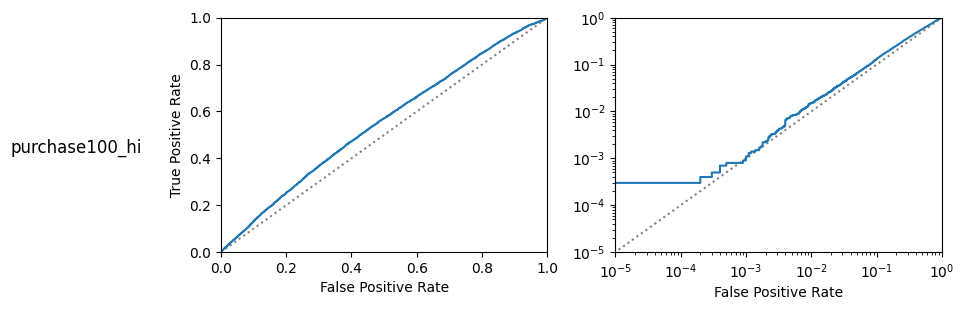

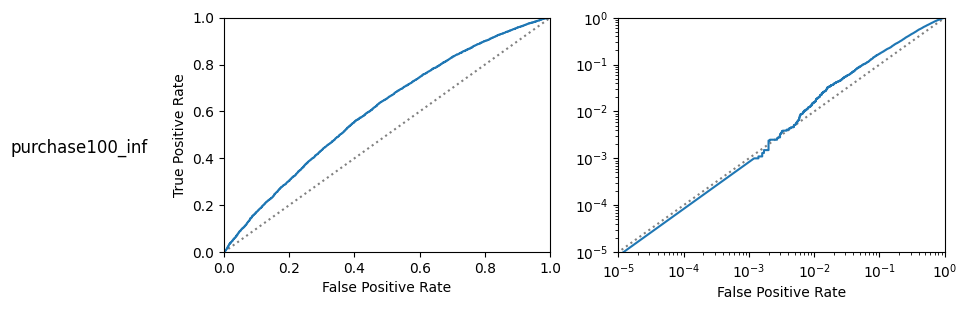

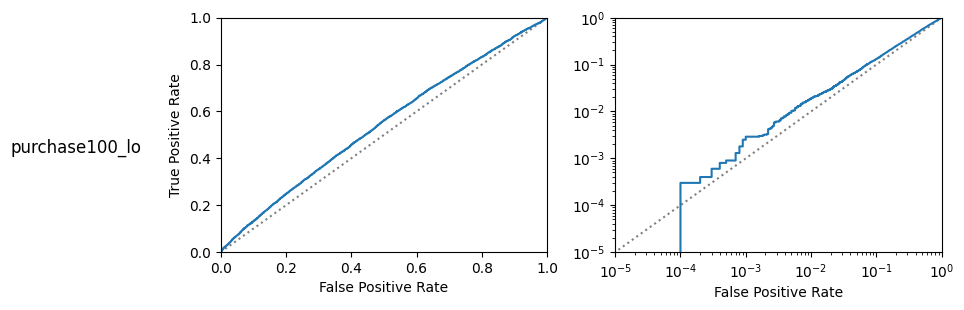

In [8]:
import matplotlib.pyplot as plt
import matplotlib

for scenario in scenarios:
    fpr = all_scores[scenario]['train']['fpr']
    tpr = all_scores[scenario]['train']['tpr']
    fig = generate_roc(fpr, tpr)
    fig.suptitle(f"{scenario}", x=-0.1, y=0.5)
    fig.tight_layout(pad=1.0)

In [9]:
import pandas as pd

for scenario in scenarios:
    print(scenario)
    scores = all_scores[scenario]['train']
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))

purchase100_hi


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0009,0.0151,0.0651,0.1315,0.1926,0.2523,0.549812,0.0744,0.5372


purchase100_inf


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0,0.0156,0.0903,0.1708,0.2361,0.3038,0.606731,0.1596,0.5798


purchase100_lo


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0025,0.0189,0.0708,0.1322,0.191,0.2483,0.54114,0.0626,0.5313


## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaLab.

In [10]:
import zipfile

phases = ['dev', 'final']

with zipfile.ZipFile("lira_predictions_purchase100.zip", 'w') as zipf:
    for scenario in tqdm(scenarios, desc="scenario"): 
        for phase in tqdm(phases, desc="phase"):
            root = os.path.join(CHALLENGE, scenario, phase)
            for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
                path = os.path.join(root, model_folder)
                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    zipf.write(file)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}. You need to provide predictions for all challenges")

scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/2 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

phase:   0%|          | 0/2 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

phase:   0%|          | 0/2 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]